In [0]:
#!pip install tensorflow==1.15
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 39kB/s 
     |████████████████████████████████| 512kB 57.4MB/s 
     |████████████████████████████████| 3.8MB 43.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=e36f0f54e19bc8340bab3da52f319c57c74737e66426b7c3c26d78d87ea47a36
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninst

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.layers import Input, Lambda, Dense, Dropout
from keras.models import Model
import keras.backend as K
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import os.path as path_

import os

Using TensorFlow backend.


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
start_epoch = 25
epoch_iterator = start_epoch
batch_size = 32
model_id = '0'
dropout_rate = 0.4
lr = 0.0001
reg = 0.001

In [0]:
elmo_embeder = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)

In [0]:
test_data = pd.read_csv('../Dataset/test_dataset.csv', encoding='utf-8')
tweets = pd.read_csv('../Data to predict/tweets.csv', encoding='utf-8')

X = np.asarray(tweets['text'])

y_test = list(test_data['sentiment'])
X_test = list(test_data['content'])

le = preprocessing.LabelEncoder()
le.fit(y_test)

def encode(labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

y_test_one_hot = encode(y_test)

X_test = np.asarray(X_test)

y_test = np.asarray(y_test_one_hot)

print(X.shape[0])
print(X_test.shape[0])

def ELMoEmbedding(x):
    return elmo_embeder(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]


750000
12800


In [0]:
# Model


input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(embedding)
do = Dropout(dropout_rate)(dense)
dense = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(do)
do = Dropout(dropout_rate)(dense)
dense = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(do)
do = Dropout(dropout_rate)(dense)
dense = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(do)
do = Dropout(dropout_rate)(dense)
dense = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(do)
pred = Dense(8, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr), metrics=['accuracy'])
print(model.summary())

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2626

In [0]:
# Predict test data

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('elmo-'+model_id+'-epoch-'+str(epoch_iterator)+'.h5')  
    predicts = model.predict(X_test, batch_size=128, verbose=1)

y_test = decode(y_test)
y_preds = decode(predicts)

12800/12800 [==============================] - 34s 3ms/step


In [0]:
# Print results


print(metrics.confusion_matrix(y_test, y_preds))

print(metrics.classification_report(y_test, y_preds))

print(accuracy_score(y_test, y_preds))

[[1293   16   16    2    2   14   16    8]
 [  21  902   45  297   35  203  219   89]
 [  17   23 1278   14    0   39   19    9]
 [  12  285   37  837   38  246  165  117]
 [   0   40    0   23 1303   10    7   21]
 [  46  238  108  202   14  802  196  197]
 [  12  201   24  152    7  105  868   60]
 [  55  250   96  309   27  493  195  425]]
              precision    recall  f1-score   support

       anger       0.89      0.95      0.92      1367
   happiness       0.46      0.50      0.48      1811
        hate       0.80      0.91      0.85      1399
     neutral       0.46      0.48      0.47      1737
      relief       0.91      0.93      0.92      1404
     sadness       0.42      0.44      0.43      1803
    surprise       0.52      0.61      0.56      1429
       worry       0.46      0.23      0.31      1850

    accuracy                           0.60     12800
   macro avg       0.61      0.63      0.62     12800
weighted avg       0.59      0.60      0.59     12800

0.60

In [0]:
#saving test data predicted lables

test_data_sentiments = pd.DataFrame(y_preds, columns=['predicted_sentiments'])
test_data_sentiments.to_csv('test_with_pred_label_elmo.csv', index=False, header=True, encoding="utf-8")

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 <a list of 7 Text major ticklabel objects>)

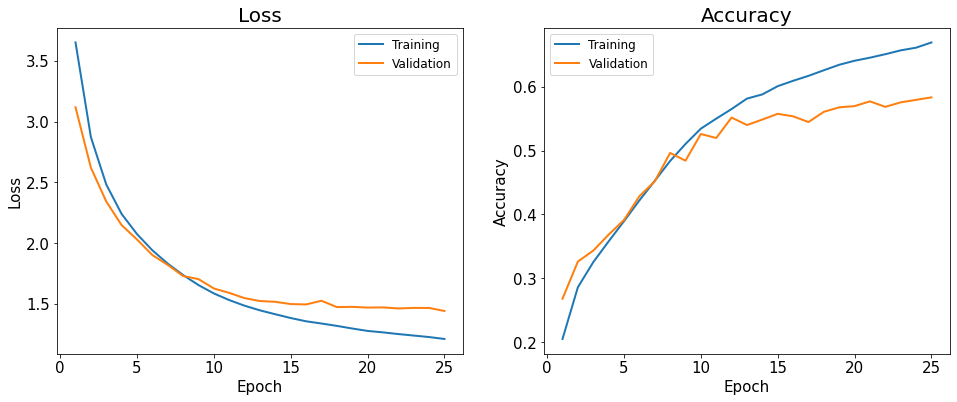

In [0]:
# Plot results

logs_ = pd.read_csv('logs-'+model_id+'.csv', encoding="utf-8")

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(logs_['epoch_num'], logs_['train_loss'], linewidth=2)
plt.plot(logs_['epoch_num'], logs_['val_loss'], linewidth=2)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(['Training', 'Validation'], fontsize=12)
plt.title('Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(logs_['epoch_num'], logs_['train_accuracy'], linewidth=2)
plt.plot(logs_['epoch_num'], logs_['val_accuracy'], linewidth=2)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(['Training', 'Validation'], fontsize=12)
plt.title('Accuracy', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


In [0]:
# Predict Collected Tweeter Data


with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('elmo-'+model_id+'-epoch-'+str(epoch_iterator)+'.h5')  
    predicts = model.predict(X, batch_size=128, verbose=1)

tweet_preds = decode(predicts)


750000/750000 [==============================] - 2805s 4ms/step


In [0]:
tweets['predicted_sentiment'] = tweet_preds
tweets_sentiments = pd.DataFrame(tweet_preds, columns=['predicted_sentiments'])

#saving test data predicted lables
#tweets.to_csv('predicted_tweets_elmo.csv', index=False, header=True, encoding="utf-8")
tweets_sentiments.to_csv('tweets_with_pred_label_elmo.csv', index=False, header=True, encoding="utf-8")